
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sbn

In [263]:
# Importando xml-roberta-base
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [254]:
print(f'Quantidade de tokens que xml-roberta-base tem no vocabulário: {len(tokenizer.vocab)}')

Quantidade de tokens que xml-roberta-base tem no vocabulário: 250002


In [261]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [262]:
print('bos_token_id <s>:', tokenizer.bos_token_id)
print('eos_token_id </s>:', tokenizer.eos_token_id)
print('sep_token_id </s>:', tokenizer.sep_token_id)
print('pad_token_id <pad>:', tokenizer.pad_token_id)

bos_token_id <s>: 0
eos_token_id </s>: 2
sep_token_id </s>: 2
pad_token_id <pad>: 1


In [264]:
# Importando dataset
df = pd.read_csv(f'../datasets/b2w_preprocessed.csv')

In [266]:
df.shape

(71516, 2)

In [267]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [268]:
# Dividindo dataset para testes em menores quantidades, não necessário caso use a base completa:
batch_1, batch_2 = train_test_split(df, test_size=0.5, stratify=df['rating'], random_state=42)
batch_3, batch_4 = train_test_split(batch_2, test_size=0.5, stratify=batch_2['rating'], random_state=42)
batch_5, batch_6 = train_test_split(batch_4, test_size=0.5, stratify=batch_4['rating'], random_state=42)
batch_7, batch_8 = train_test_split(batch_6, test_size=0.5, stratify=batch_6['rating'], random_state=42)
batch_9, batch_10 = train_test_split(batch_8, test_size=0.5, stratify=batch_8['rating'], random_state=42)
batch_11, batch_12 = train_test_split(batch_10, test_size=0.5, stratify=batch_10['rating'], random_state=42)
print(f'batch_01: {batch_1.shape}')
print(f'batch_02: {batch_2.shape}')
print(f'batch_03: {batch_3.shape}')
print(f'batch_04: {batch_4.shape}')
print(f'batch_05: {batch_5.shape}')
print(f'batch_06: {batch_6.shape}')
print(f'batch_07: {batch_7.shape}')
print(f'batch_08: {batch_8.shape}')
print(f'batch_09: {batch_9.shape}')
print(f'batch_10: {batch_10.shape}')
print(f'batch_11: {batch_11.shape}')
print(f'batch_12: {batch_12.shape}')

batch_01: (35758, 2)
batch_02: (35758, 2)
batch_03: (17879, 2)
batch_04: (17879, 2)
batch_05: (8939, 2)
batch_06: (8940, 2)
batch_07: (4470, 2)
batch_08: (4470, 2)
batch_09: (2235, 2)
batch_10: (2235, 2)
batch_11: (1117, 2)
batch_12: (1118, 2)


In [269]:
df = df

In [270]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

In [271]:
# Somente para teste
#reviews = ['otimo','ruim','otimo','ruim','otimo','ruim','otimo','ruim','otimo','ruim']
#labels = [1,0,1,0,1,0,1,0,1,0]

In [272]:
reviews = df['review_text']
labels = df['rating']

In [210]:
embeddings = []
attention_masks = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(
        str(review), 
        return_tensors="pt", 
        padding=True, 
        truncation=True,
        max_length=128
    )
    
    # capturando attentions masks
    attention_mask = inputs["attention_mask"]
    
    with torch.no_grad():
        output = model(**inputs)
    
    # adicionando embeddings tokenizados no array embeddings
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())
    
    # adicionando attention masks no array attention_masks
    attention_masks.append(attention_mask.numpy())

Processing: 100%|██████████| 1118/1118 [01:49<00:00, 10.20it/s]


In [211]:
print(len(embeddings))
print(len(attention_masks))

1118
1118


In [212]:
# Feature based 1 - Concatena Média, Min e Max
# Calculando valores estatísticos:
mean_values = np.mean(embeddings, axis=1)
min_values = np.min(embeddings, axis=1)
max_values = np.max(embeddings, axis=1)

In [213]:
# Conferindo dimensões das matrizes dos valores estatísticos
print(mean_values.shape)
print(min_values.shape)
print(max_values.shape)

(1118, 768)
(1118, 768)
(1118, 768)


In [216]:
# Ajustando matriz de attention masks
max_columns = max(arr.shape[1] for arr in attention_masks)
combined_attention_masks_array = np.zeros((len(attention_masks), max_columns), dtype=np.int64)

for i, arr in enumerate(attention_masks):
    combined_attention_masks_array[i, :arr.shape[1]] = arr

print(combined_attention_masks_array)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [273]:
# Concatenando valores estatísticos e attention masks
combined_data = np.hstack((mean_values, min_values, max_values, combined_attention_masks_array))

In [274]:
# Conferindo dimensões das matrizes
# Quantidade de instancias e dimensão do embedding
print(combined_data.shape)

(1118, 2432)


In [219]:
# Convertendo labels em numpy array
labels = np.array(labels)
print(labels.shape)

(1118,)


In [220]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

In [221]:
# Convertendo dados de treino em tensores do tensorflow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [222]:
# Convertendo dados de teste em tensores do tensorflow
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [243]:
# Hiper-parâmetros:
HIDDEN_LAYER = 24
INPUT_DIM = X_train_tensor.shape[1]
DROPOUT = 0.10 #Dropout: 0, 10%
LEARNING_RATE = 2.5e-5 #Learning rate: 2.5e-5, 5e-5
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]
FOLDS = 10
EPOCHS = 5
BATCH_SIZE = 32
VERBOSE = 0

In [239]:
# Arquitetura de rede MLP
model = Sequential([
    Dense(HIDDEN_LAYER, activation='relu', input_dim=INPUT_DIM),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 24)                58392     
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 58,417
Trainable params: 58,417
Non-trainable params: 0
_________________________________________________________________


In [240]:
# Compilando o modelo
model.compile(
    optimizer=OPTIMIZER, 
    loss=LOSS, 
    metrics=METRICS
)

In [227]:
# Cross-validation
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [244]:
# Treinando o modelo:

fold = 0

# -----------------------------------------------------------------------------

train_loss_history = []
train_accuracy_history = []

fold_train_losses = []
fold_train_accuracies = []
fold_train_f1_scores = []

train_tprs = []
train_aucs = []
train_mean_fpr = np.linspace(0, 1, 100)

# -----------------------------------------------------------------------------

fold_accuracies = []
fold_f1_scores = []

for train_indices, val_indices in tqdm((kf.split(combined_data)),desc="Processing"):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_data[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_data[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
        
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    # -----------------------------------------------------------------------------
    
    # train losses ecah fold
    fold_train_losses.append(model_history.history['val_loss'])
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score each fold
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_tprs.append(np.interp(train_mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)
    
    # -----------------------------------------------------------------------------
    
    # val predictions
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # val acc
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    # val f1
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    # val loss
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print('Finished train!')

Processing: 0it [00:00, ?it/s]

fold = 1
4/4 [==============================] - 0s 2ms/step


Processing: 1it [00:01,  1.23s/it]

fold = 2
4/4 [==============================] - 0s 2ms/step


Processing: 2it [00:01,  1.13it/s]

fold = 3
4/4 [==============================] - 0s 1ms/step


Processing: 3it [00:02,  1.31it/s]

fold = 4
4/4 [==============================] - 0s 1ms/step


Processing: 4it [00:03,  1.39it/s]

fold = 5
4/4 [==============================] - 0s 1ms/step


Processing: 5it [00:03,  1.48it/s]

fold = 6
4/4 [==============================] - 0s 1ms/step


Processing: 6it [00:04,  1.54it/s]

fold = 7
4/4 [==============================] - 0s 2ms/step


Processing: 7it [00:04,  1.57it/s]

fold = 8
4/4 [==============================] - 0s 1ms/step


Processing: 8it [00:05,  1.56it/s]

fold = 9
4/4 [==============================] - 0s 1ms/step


Processing: 9it [00:06,  1.57it/s]

fold = 10
4/4 [==============================] - 0s 1ms/step


Processing: 10it [00:06,  1.46it/s]

Finished train!


In [245]:
train_accuracy_mean_value = round(np.mean([np.mean(train_ac) for train_ac in fold_train_accuracies]),4)
train_f1_mean_value = round(np.mean([np.mean(train_f1) for train_f1 in fold_train_f1_scores]),4)
print(f"Media Accuracy Treino: {train_accuracy_mean_value}")
print(f"Media f1 score Treino: {train_f1_mean_value}")
print('-'*80)
print("Media Accuracy Validacao:", np.mean(fold_accuracies))
print("Media f1 score Validacao", np.mean(fold_f1_scores))

Media Accuracy Treino: 0.7819
Media f1 score Treino: 0.8129
--------------------------------------------------------------------------------
Media Accuracy Validacao: 0.8202300514800516
Media f1 score Validacao 0.8140743090181963


In [246]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_loss_folds_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(train_mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{desc}_train_roc_auc_curve_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_val_confusion_matrix_test_{TRAIN_NUM}.png')
    plt.show()

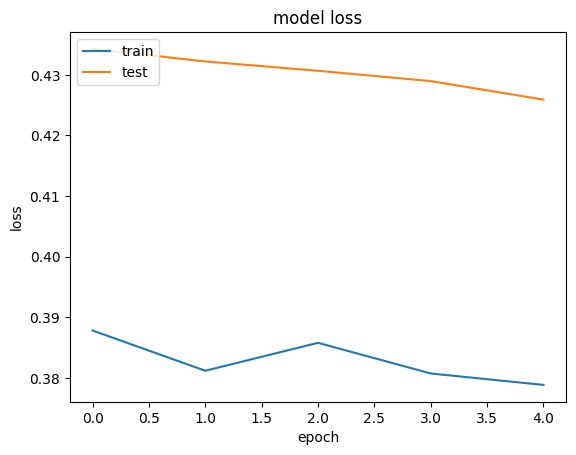

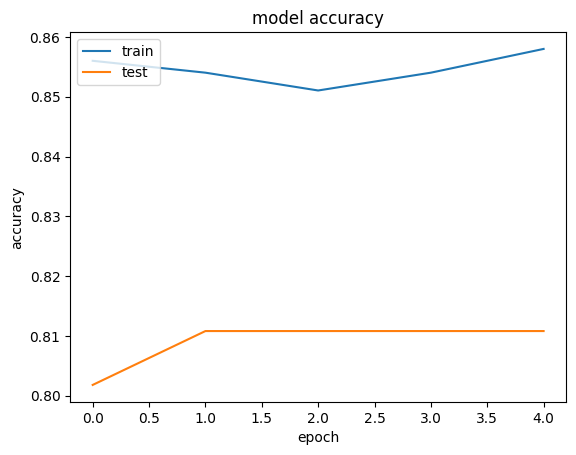

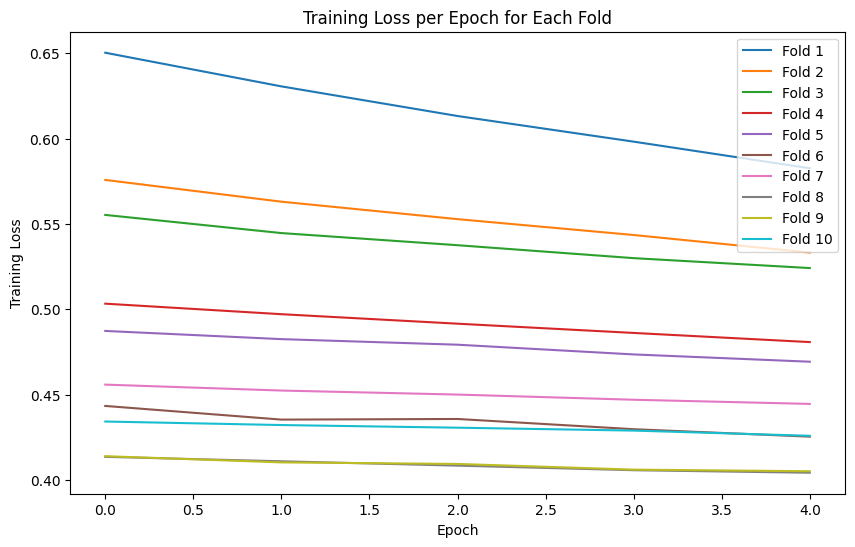

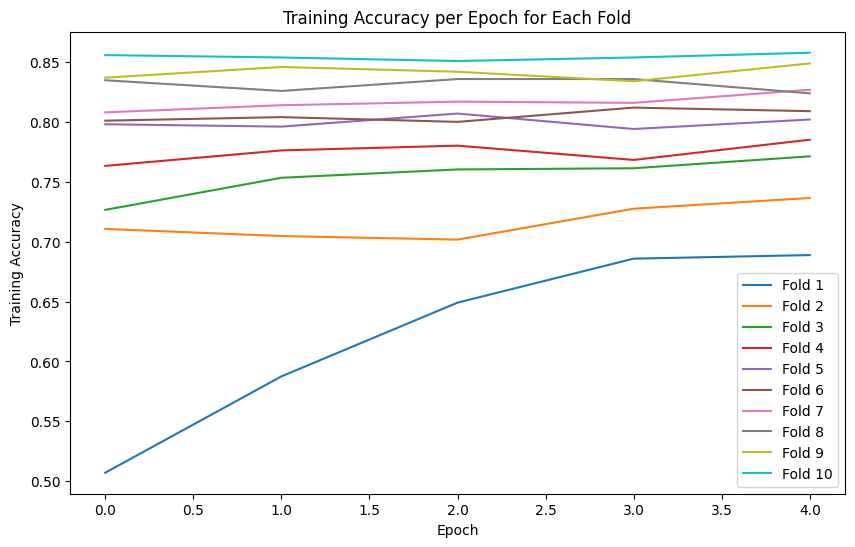

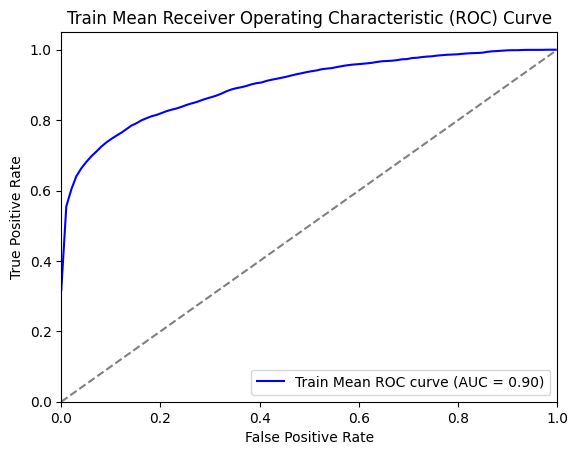

In [247]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_train_folds(fold_train_losses, 'Loss')
plot_train_folds(fold_train_accuracies, 'Accuracy')

train_mean_tpr = np.mean(train_tprs, axis=0)
train_mean_auc = auc(train_mean_fpr, train_mean_tpr)
plot_roc_auc_curve('Train', train_mean_tpr, train_mean_auc)

In [248]:
predict = np.round(model.predict(X_val_fold_tensor))

4/4 [==============================] - 0s 2ms/step


In [249]:
accuracy = accuracy_score(y_val_fold_tensor, predict)
accuracy

0.8108108108108109

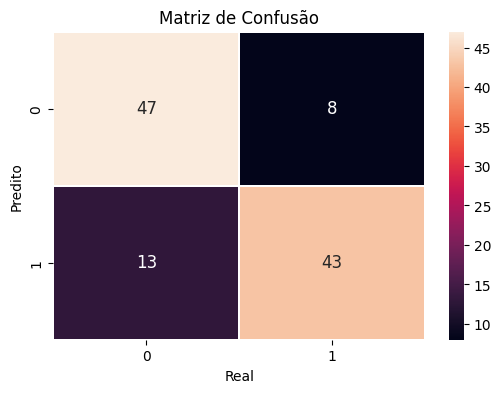

In [250]:
cm = confusion_matrix(y_val_fold_tensor, predict)
plot_confunsion_matrix(cm)